# Notebook de Validación y Mejoras

1.  **Generar Ground Truth**: Etiquetar manualmente imágenes para tener una referencia fiable.
2.  **Validar el Modelo**: Calcular Accuracy, Precision, Recall y Matriz de Confusión.
3.  **Experimentar**: Probar mejoras como análisis de textura y Transformada de Hough.

---
## 1. Configuración e Imports

In [4]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output
import json
import random

# Configuración de visualización
plt.rcParams['figure.figsize'] = (15, 10)

def cargar_plazas(filepath="plazas.pickle"):
    try:
        with open(filepath, 'rb') as f:
            plazas = pickle.load(f)
        print(f"✅ Cargadas {len(plazas)} plazas desde {filepath}")
        return plazas
    except FileNotFoundError:
        print(f"❌ No se encontró {filepath}. Ejecuta configurar_plazas.py primero.")
        return []

plazas = cargar_plazas()

✅ Cargadas 51 plazas desde plazas.pickle


---
## 2. Pipeline Base (Mejorado)

Incluye **CLAHE** para normalización de luz y **Padding** opcional para evitar bordes.

In [5]:
def preprocess_image(image):
    #Convierte a gris, aplica CLAHE y suavizado.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # CLAHE: Contrast Limited Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Gaussian Blur para reducir ruido
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    return blur

def get_roi(image, rect, padding_percent=0.0):
    #Extrae el ROI de una imagen, opcionalmente reduciendo bordes.
    x, y, w, h = rect
    
    if padding_percent > 0:
        pad_w = int(w * padding_percent)
        pad_h = int(h * padding_percent)
        x += pad_w
        y += pad_h
        w -= 2 * pad_w
        h -= 2 * pad_h
        
    return image[y:y+h, x:x+w]

def analyze_space_basic(roi_thresh):
    #Pipeline Básico: Conteo de píxeles blancos.
    return cv2.countNonZero(roi_thresh)

def analyze_space_texture(roi_gray):
    #Pipeline Experimental: Varianza (Textura).
    # Calcula la desviación estándar de la intensidad de píxeles
    # Asfalto liso -> Baja std dev
    # Coche -> Alta std dev
    mean, std_dev = cv2.meanStdDev(roi_gray)
    return std_dev[0][0]

---
## 3. Herramienta de Etiquetado Manual (Ground Truth)

Esta herramienta te permite recorrer imágenes y marcar qué plazas están REALMENTE ocupadas.
Los resultados se guardan en `ground_truth.json`.

In [6]:
data_dir = Path("data")
image_files = sorted(list(data_dir.glob("*.jpg"))) 
ground_truth = {}
GT_FILE = "ground_truth.json"


# Cargar etiquetas existentes si hay
if Path(GT_FILE).exists():
    with open(GT_FILE, 'r') as f:
        ground_truth = json.load(f)
    print(f"📂 Cargadas {len(ground_truth)} imágenes etiquetadas previamente.")

📂 Cargadas 8 imágenes etiquetadas previamente.


In [ ]:
# Widgets para la UI de etiquetado
btn_ocupado = widgets.Button(description="Ocupado (1)", button_style='danger')
btn_libre = widgets.Button(description="Libre (0)", button_style='success')
btn_skip = widgets.Button(description="Saltar Imagen", button_style='warning')
btn_finish = widgets.Button(description="Guardar y Salir", button_style='primary')
out_img = widgets.Output()
lbl_info = widgets.Label(value="Iniciando...")

current_img_idx = 0
current_plaza_idx = 0
current_labels = []

def show_next_roi():
    global current_img_idx, current_plaza_idx, current_labels
    
    if current_img_idx >= len(image_files):
        lbl_info.value = "¡Todas las imágenes procesadas!"
        save_ground_truth()
        return

    img_path = image_files[current_img_idx]
    img_name = img_path.name
    
    # Si ya está etiquetada, saltar
    if img_name in ground_truth:
        current_labels = [] # Reset para la siguiente
        current_img_idx += 1
        current_plaza_idx = 0
        show_next_roi()
        return

    if current_plaza_idx >= len(plazas):
        # Imagen terminada
        ground_truth[img_name] = current_labels
        print(f"✅ Guardada {img_name}")
        current_labels = []
        current_img_idx += 1
        current_plaza_idx = 0
        show_next_roi()
        return

    # Mostrar ROI actual
    img = cv2.imread(str(img_path))
    x, y, w, h = plazas[current_plaza_idx]
    roi = img[y:y+h, x:x+w]
    
    # Dibujar contexto (un poco más grande)
    pad = 20
    y1, y2 = max(0, y-pad), min(img.shape[0], y+h+pad)
    x1, x2 = max(0, x-pad), min(img.shape[1], x+w+pad)
    context_roi = img[y1:y2, x1:x2].copy()
    
    # Dibujar rectángulo en el contexto para saber cual es
    cv2.rectangle(context_roi, (x-x1, y-y1), (x-x1+w, y-y1+h), (0, 255, 255), 2)
    
    roi_rgb = cv2.cvtColor(context_roi, cv2.COLOR_BGR2RGB)
    
    # Mostrar en widget
    with out_img:
        clear_output(wait=True)
        plt.figure(figsize=(3,3))
        plt.imshow(roi_rgb)
        plt.axis('off')
        plt.title(f"Img: {current_img_idx} | Plaza: {current_plaza_idx+1}")
        plt.show()
        
    lbl_info.value = f"Etiquetando: {img_name} - Plaza {current_plaza_idx+1}/{len(plazas)}"

def on_ocupado(b):
    global current_plaza_idx
    current_labels.append(1)
    current_plaza_idx += 1
    show_next_roi()

def on_libre(b):
    global current_plaza_idx
    current_labels.append(0)
    current_plaza_idx += 1
    show_next_roi()

def on_save(b):
    save_ground_truth()
    print("💾 Ground Truth guardado manualmente.")

def save_ground_truth():
    with open(GT_FILE, 'w') as f:
        json.dump(ground_truth, f)

btn_ocupado.on_click(on_ocupado)
btn_libre.on_click(on_libre)
btn_finish.on_click(on_save)

display(widgets.VBox([lbl_info, out_img, widgets.HBox([btn_ocupado, btn_libre, btn_finish])]))

# Usando los botones para marcar varias imágenes completas, se guardará autómaticamente en ground_truth.json

---
## 4. Validación: Métricas y Matriz de Confusión

Calcula Accuracy Global, Precision, Recall y muestra la Matriz de Confusión.
Compara tus etiquetas manuales con la predicción del sistema.

📊 Validando con 8 imágenes etiquetadas...

🏆 Accuracy Global: 26.72%

📜 Reporte de Clasificación:
              precision    recall  f1-score   support

       Libre       0.22      1.00      0.36        85
     Ocupado       1.00      0.07      0.14       323

    accuracy                           0.27       408
   macro avg       0.61      0.54      0.25       408
weighted avg       0.84      0.27      0.19       408



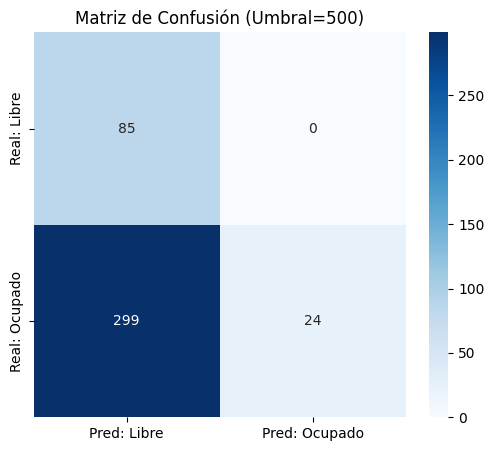

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

def validar_modelo(umbral=500, padding=0.0):
    y_true = []
    y_pred = []
    
    if not ground_truth:
        print("⚠️ No hay Ground Truth. Etiqueta algunas imágenes primero.")
        return

    print(f"📊 Validando con {len(ground_truth)} imágenes etiquetadas...")
    
    for img_name, labels in ground_truth.items():
        img_path = data_dir / img_name
        image = cv2.imread(str(img_path))
        
        # 1. Pipeline
        blur = preprocess_image(image)
        binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                     cv2.THRESH_BINARY_INV, 25, 15)
        binary = cv2.medianBlur(binary, 5)
        
        # 2. Clasificación
        for idx, rect in enumerate(plazas):
            if idx >= len(labels): break
            
            roi = get_roi(binary, rect, padding_percent=padding)
            count = analyze_space_basic(roi)
            
            prediction = 1 if count > umbral else 0
            
            y_true.append(labels[idx])
            y_pred.append(prediction)

    # 3. Métricas
    acc = accuracy_score(y_true, y_pred)
    print(f"\n🏆 Accuracy Global: {acc*100:.2f}%")
    print("\n📜 Reporte de Clasificación:")
    print(classification_report(y_true, y_pred, target_names=['Libre', 'Ocupado']))
    
    # 4. Matriz de Confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: Libre', 'Pred: Ocupado'], yticklabels=['Real: Libre', 'Real: Ocupado'])
    plt.title(f'Matriz de Confusión (Umbral={umbral})')
    plt.show()

# Probar con umbral 500 y sin padding
validar_modelo(umbral=500, padding=0.0)

---
## 5. Experimentos de Mejora

### Ex. 1: Padding (Recorte de bordes)
¿Mejora si recortamos un 20% los bordes para evitar pintar líneas del suelo?

🧪 Probando con Padding del 20%...
📊 Validando con 8 imágenes etiquetadas...

🏆 Accuracy Global: 20.83%

📜 Reporte de Clasificación:
              precision    recall  f1-score   support

       Libre       0.21      1.00      0.34        85
     Ocupado       0.00      0.00      0.00       323

    accuracy                           0.21       408
   macro avg       0.10      0.50      0.17       408
weighted avg       0.04      0.21      0.07       408



c:\Users\nico.azcarate\OneDrive - Universidad de Deusto\Escritorio\DEUSTO\2025-2026\VisionCompu\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nico.azcarate\OneDrive - Universidad de Deusto\Escritorio\DEUSTO\2025-2026\VisionCompu\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nico.azcarate\OneDrive - Universidad de Deusto\Escritorio\DEUSTO\2025-2026\VisionCompu\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill

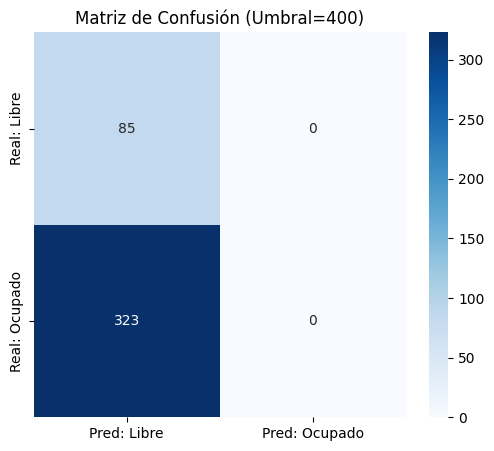

In [8]:
print("🧪 Probando con Padding del 20%...")
validar_modelo(umbral=400, padding=0.2) # Bajamos un poco umbral porque hay menos pixeles

### Ex. 2: Análisis de Textura (Varianza)
Las sombras suelen ser lisas. Los coches tienen textura.
Vamos a graficar: **PixelCount vs Textura (StdDev)** para ver si se separan mejor.

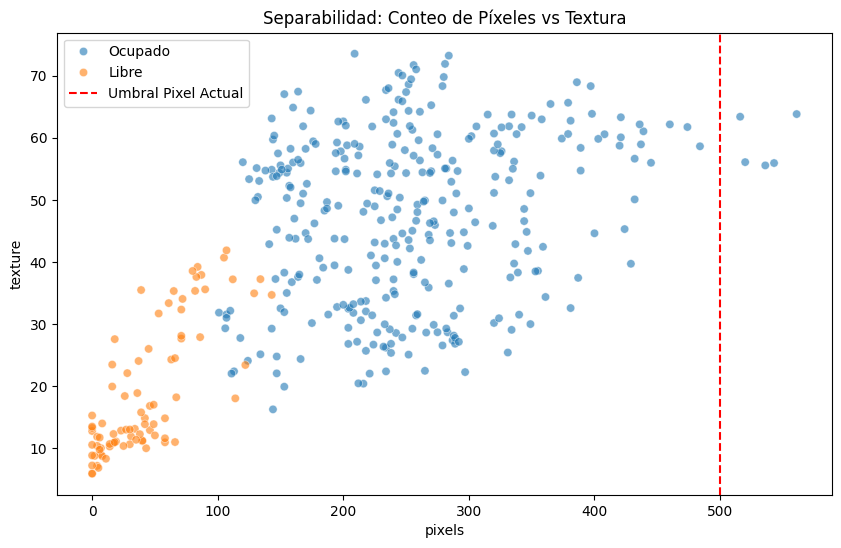

In [9]:
def comparar_metricas():
    if not ground_truth: return

    data = []
    
    for img_name, labels in ground_truth.items():
        image = cv2.imread(str(data_dir / img_name))
        blur = preprocess_image(image)
        
        # Copia binaria para conteo normal
        binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 15)

        for idx, rect in enumerate(plazas):
            if idx >= len(labels): break
            
            # Metrica 1: Conteo Píxeles
            roi_bin = get_roi(binary, rect, 0.1)
            count = analyze_space_basic(roi_bin)
            
            # Metrica 2: Textura (Std Dev en Gris)
            roi_gray = get_roi(blur, rect, 0.1)
            texture = analyze_space_texture(roi_gray)
            
            data.append({
                'label': 'Ocupado' if labels[idx] == 1 else 'Libre',
                'pixels': count,
                'texture': texture
            })
    
    # Graficar
    import pandas as pd
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='pixels', y='texture', hue='label', alpha=0.6)
    plt.title("Separabilidad: Conteo de Píxeles vs Textura")
    plt.axvline(x=500, color='r', linestyle='--', label='Umbral Pixel Actual')
    plt.legend()
    plt.show()

comparar_metricas()

---
## 6. Experimento: Transformada de Hough (Líneas)

Intento de detectar las líneas del parking. 
*   Si detectamos muchas líneas verticales/horizontales claras -> Probablemente **LIBRE**.
*   Si hay caos o no hay líneas rectas -> Probablemente **OCUPADO**.

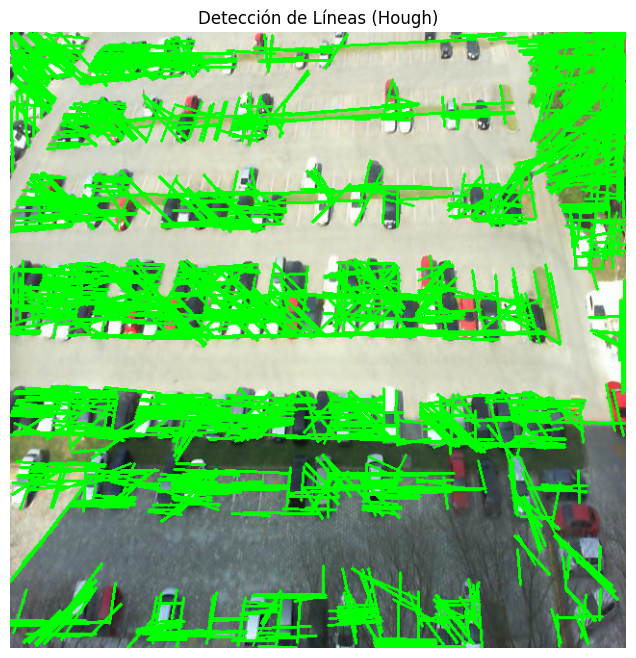

In [10]:
def test_hough(img_path):
    img = cv2.imread(str(img_path))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    # Detectar líneas
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=30, maxLineGap=10)
    
    output = img.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(output, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title("Detección de Líneas (Hough)")
    plt.axis('off')
    plt.show()

# Probar con una imagen aleatoria
if image_files:
    test_hough(random.choice(image_files))